In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
data = pd.read_csv('../input/stock-time-series-20050101-to-20171231/GOOGL_2006-01-01_to_2018-01-01.csv',
                   index_col=['Date'], parse_dates=['Date'])
print("Data shape:", data.shape)

Data shape: (3019, 6)


In [3]:
data.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [4]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


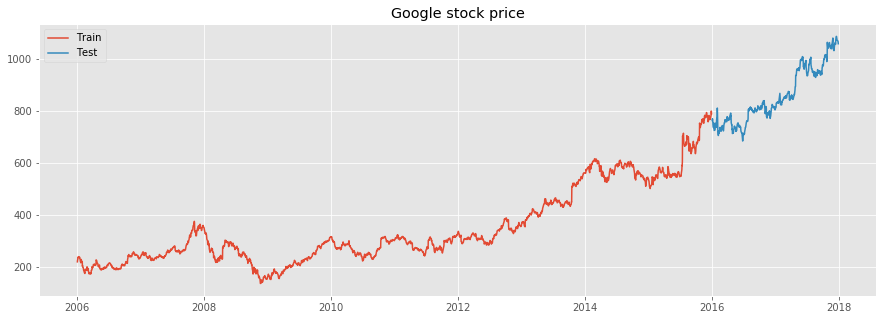

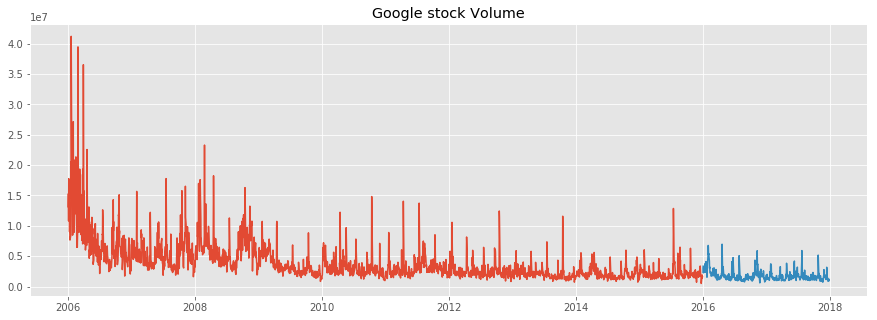

In [5]:
plt.figure(figsize=(15,5))
plt.title('Google stock price')
plt.plot(data[:'2015'].iloc[:,1:2])
plt.plot(data['2016':].iloc[:,1:2])
plt.legend(['Train','Test'], loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.title('Google stock Volume')
plt.plot(data[:'2015'].iloc[:,4:5])
plt.plot(data['2016':].iloc[:,4:5])
plt.show()

## Let's first create a model considering only past High price

In [6]:
X = data.iloc[:,1:2]
X.head()

,High
Date,
2006-01-03,218.05
2006-01-04,224.70
2006-01-05,226.00
2006-01-06,235.49
2006-01-09,236.94


## Scale data between 0 & 1

In [7]:
scaler = MinMaxScaler()
X['High'] = scaler.fit_transform(X['High'].values.reshape(-1,1))
print(X.shape)

(3019, 1)


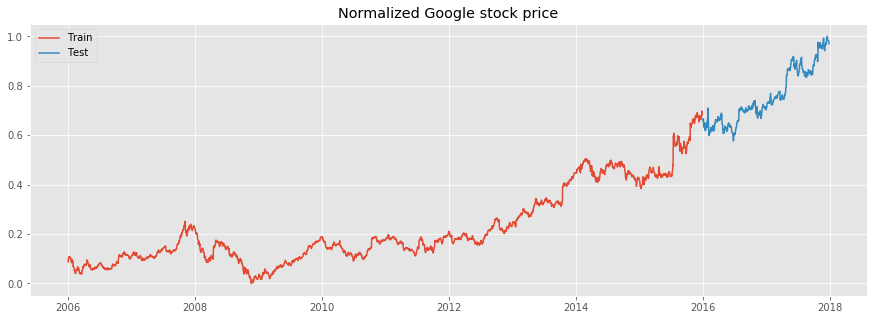

In [8]:
plt.figure(figsize=(15,5))
plt.title('Normalized Google stock price')
plt.plot(X[:'2015'])
plt.plot(X['2016':])

plt.legend(['Train','Test'], loc='best')
plt.show()

In [9]:
def preprocess_data(X,seqlen,n_features):
    X_seq = []
    y = []
    
    for i in range(seqlen, len(X)):
        if n_features == 1:
            X_seq.append(X.iloc[i-seqlen:i,0])
        else: 
            X_seq.append(X.iloc[i-seqlen:i,:].values)
        y.append(X.iloc[i,0])
    
    X_seq = np.array(X_seq)
    y = np.array(y)
    
    if n_features == 1:
        X_seq = np.reshape(X_seq,(X_seq.shape[0],seqlen,1))
    
    return X_seq, y

In [10]:
X_train, y_train = preprocess_data(X[:'2015'], 60, 1)
X_test, y_test = preprocess_data(X['2016':], 60, 1)

In [11]:
def create_model(dropout):
    model = Sequential()

    model.add(LSTM(200,input_shape=(X_train.shape[1],X_train.shape[2]),
                   activation='tanh',return_sequences=True))
    if dropout == True:
        model.add(Dropout(0.2))
        
    model.add(LSTM(10,activation='tanh',return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='rmsprop')
    
    return model

model = create_model(dropout=True)
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
2456/2456 [==============================] - 11s 5ms/step - loss: 0.0032
Epoch 2/10
2456/2456 [==============================] - 10s 4ms/step - loss: 8.6098e-04
Epoch 3/10
2456/2456 [==============================] - 10s 4ms/step - loss: 6.5589e-04
Epoch 4/10
2456/2456 [==============================] - 10s 4ms/step - loss: 5.8585e-04
Epoch 5/10
2456/2456 [==============================] - 10s 4ms/step - loss: 5.1248e-04
Epoch 6/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.6012e-04
Epoch 7/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.3378e-04
Epoch 8/10
2456/2456 [==============================] - 10s 4ms/step - loss: 3.7898e-04
Epoch 9/10
2456/2456 [==============================] - 10s 4ms/step - loss: 3.6143e-04
Epoch 10/10
2456/2456 [==============================] - 10s 4ms/step - loss: 3.3448e-04


In [12]:
# Make prediction with trained model
pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
pred = scaler.inverse_transform(pred.reshape(-1,1))

In [13]:
def plot_pred(prediction, true):
    plt.figure(figsize=(15,5))
    plt.title('Prediction vs reality')
    plt.plot(prediction)
    plt.plot(true)
    plt.legend(['Prediction','Real'], loc='best')
    plt.show()

In [14]:
def evaluate_prediction(prediction, true):
    print("r2 score {}".format(r2_score(prediction, true)))
    print("MAE {}".format(mean_absolute_error(prediction, true)))
    print("MSE {}".format(mean_squared_error(prediction, true)))

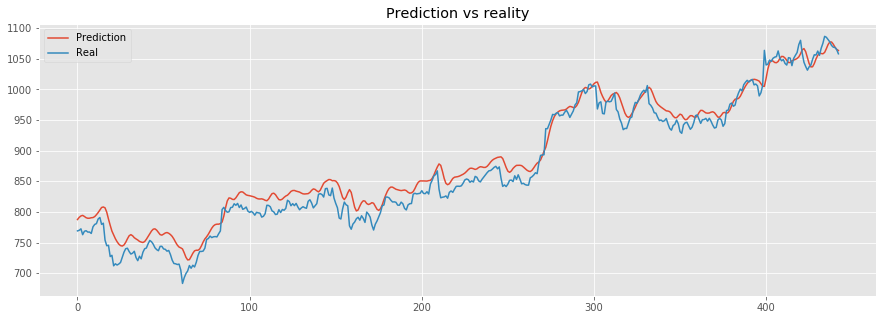

r2 score 0.9510711195582267
MAE 17.68137108383003
MSE 444.62412940142633


In [15]:
plot_pred(pred, y_test)
evaluate_prediction(pred, y_test)

In [16]:
input_data = data.iloc[:,[1,4]]

In [17]:
scaler_v = MinMaxScaler()
input_data['Volume'] = scaler_v.fit_transform(input_data['Volume'].values.reshape(-1,1))
input_data['High'] = X['High']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
X_train, y_train = preprocess_data(input_data[:'2015'], 60, 2)
X_test, y_test = preprocess_data(input_data['2016':], 60, 2)
model = create_model(dropout=True)
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
2456/2456 [==============================] - 11s 5ms/step - loss: 0.0032
Epoch 2/10
2456/2456 [==============================] - 10s 4ms/step - loss: 8.6990e-04
Epoch 3/10
2456/2456 [==============================] - 10s 4ms/step - loss: 7.0778e-04
Epoch 4/10
2456/2456 [==============================] - 10s 4ms/step - loss: 5.5957e-04
Epoch 5/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.7416e-04
Epoch 6/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.4755e-04
Epoch 7/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.0474e-04
Epoch 8/10
2456/2456 [==============================] - 10s 4ms/step - loss: 4.2389e-04
Epoch 9/10
2456/2456 [==============================] - 10s 4ms/step - loss: 3.9816e-04
Epoch 10/10
2456/2456 [==============================] - 10s 4ms/step - loss: 3.6425e-04


In [19]:
pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
pred = scaler.inverse_transform(pred.reshape(-1,1))

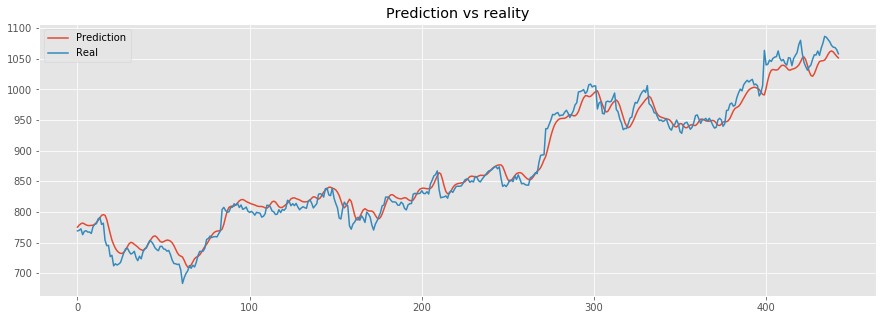

r2 score 0.9737404176272011
MAE 11.966766938840271
MSE 235.66022766751286


In [20]:
plot_pred(pred, y_test)
evaluate_prediction(pred, y_test)